In [1]:
# --- 1. Import ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# --- 2. Encoder ---
class Encoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1),  # 28 -> 14
            nn.ReLU(),
            nn.Conv2d(32, latent_dim, 4, 2, 1),   # 14 -> 7
        )

    def forward(self, x):
        return self.conv(x)  # [B, latent_dim, 7, 7]

# --- 3. Decoder ---
class Decoder(nn.Module):
    def __init__(self, latent_dim=64, out_channels=1):
        super().__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 32, 4, 2, 1),  # 7->14
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, 4, 2, 1),  # 14->28
            nn.Sigmoid()
        )

    def forward(self, z_q):
        return self.deconv(z_q)

# --- 4. Vector Quantizer ---
class VectorQuantizer(nn.Module):
    def __init__(self, num_codes=256, code_dim=64, beta=0.25):
        super().__init__()
        self.embedding = nn.Embedding(num_codes, code_dim)
        self.embedding.weight.data.uniform_(-1/num_codes, 1/num_codes)
        self.beta = beta

    def forward(self, z_e):
        z_e_perm = z_e.permute(0, 2, 3, 1).contiguous()  # [[B, D, H, W] -> [B, H, W, D]
        flat = z_e_perm.view(-1, z_e.shape[1])           # [B*H*W, D]

        # Ogni flat[i] è confrontato con tutti gli e_j nel codebook e calcolata la distanza
        dists = (flat**2).sum(1, True) - 2 * flat @ self.embedding.weight.T + (self.embedding.weight**2).sum(1)

        # indices: vettore di lunghezza N, con valori da 0 a K−1.
        indices = torch.argmin(dists, 1)

        # Rimappa nella forma [B, D, H, W] i vettori del codebook corrispondenti agli indices.
        z_q = self.embedding(indices).view(z_e_perm.shape).permute(0, 3, 1, 2).contiguous()

        #Aggiorna il codebook avvicinandolo a z_e (k-means like). 
        # qui .detach() evita che il gradiente fluisca attraverso z_q.
        codebook_loss = F.mse_loss(z_q.detach(), z_e)

        #Forza z_e a stabilizzarsi intorno a un codice z_q specifico.
        # Senza commitment_loss il codebook si adatta a z_e, ma non viceversa
        commitment_loss = self.beta * F.mse_loss(z_q, z_e.detach())
        loss = codebook_loss + commitment_loss

        #in Backward i gradienti fluiscono attraverso z_e, ignorando la quantizzazione.
        z_q = z_e + (z_q - z_e).detach()
        return z_q, loss

# --- 5. VQ-VAE Full ---
class VQVAE(nn.Module):
    def __init__(self, latent_dim=64, num_codes=256):
        super().__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.vq = VectorQuantizer(num_codes, latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss = self.vq(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, z_e, z_q, vq_loss


In [2]:
# --- 6. Data ---
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# --- 7. Train ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VQVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# --- 8. Training loop ---
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_recon, z_e, z_q, vq_loss = model(x)
        recon_loss = F.mse_loss(x_recon, x)
        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 | Loss: 0.3341
Epoch 2 | Loss: 0.0295
Epoch 3 | Loss: 0.0160
Epoch 4 | Loss: 0.0132
Epoch 5 | Loss: 0.0115
Epoch 6 | Loss: 0.0105
Epoch 7 | Loss: 0.0100
Epoch 8 | Loss: 0.0098
Epoch 9 | Loss: 0.0095
Epoch 10 | Loss: 0.0092


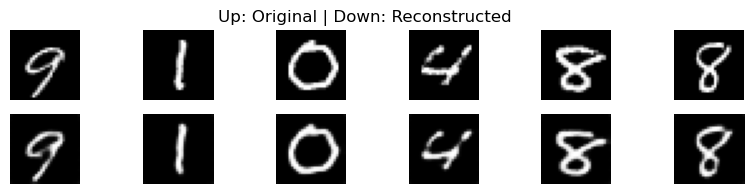

In [5]:
# --- 9. Visualizza ---
x, _ = next(iter(train_loader))
x = x.to(device)
x_recon, *_ = model(x)

plt.figure(figsize=(10, 2))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(x[i, 0].detach().cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 6, i+7)
    plt.imshow(x_recon[i, 0].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.suptitle("Up: Original | Down: Reconstructed")
plt.show()
